# COMP0189: Applied Artificial Intelligence
## Week 7 (Model Interpretation and Feature selection)


## Learning goals 🎯
1. Learn how to use different strategies for interpreting machine learning models.
2. Learn how to properly implement feature selection to avoid leaking information.

### Acknowledgements
- https://scikit-learn.org/stable/
- https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#id1

In [1]:
%pip install scikit-learn==1.6.1 matplotlib seaborn pandas


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Part 1: A common error: leaking information

We will start with a toy example to illustrate a common mistake when using feature selection. We will create a random dataset with 10.000 features and 100 samples.

In [3]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
X_test = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))
y_test = rnd.normal(size=(100,))

In [4]:
print(X.shape)

(100, 10000)


We might consider that 10.000 is a very high number of features and that we need to use feature selection. So, let's select the 5% most informative features.

In [5]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression,
                          percentile=5)
select.fit(X, y)
X_sel = select.transform(X)

print(X_sel.shape)

(100, 500)


Now we will create a pipeline to pre-process the data and fit a regression model to see if we can predict the random labels from the selected features.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, random_state=0)
pipe = make_pipeline(StandardScaler(), Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9047168401499722

These are great results but how did we get such good results on a random dataset?

These results are due to information leaking as the features were selected before spliting the data into train and test splits.

### Task 1: Implement a correct pipeline to pre-process the data, select the top 5% features and train a regression model to predict th random labels.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = make_pipeline(StandardScaler(), select,  Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

-0.03695402379065271

These results make more sense from what we would expet with random labels.

# Part 2: Model interpretation and feature selection

## Breast Cancer Wisconsin (Diagnostic) Dataset (WDBC)

For this part, we will use data from the **Breast Cancer Wisconsin (Diagnostic) Dataset (WDBC)**.

**Source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)  

**Samples:** 569 (357 Benign, 212 Malignant)  

**Target Variable:** Diagnosis (**M** = Malignant, **B** = Benign)  

### Features (30 total)
- **10 Cell Nucleus Characteristics**, including:
  - Radius, Texture, Perimeter, Area, Smoothness, Compactness, Concavity, Concave Points, Symmetry, Fractal Dimension  
- Each feature has **Mean, Standard Error (SE), and Worst** (largest mean of top 3 values) variations  



In [8]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load dataset
data = load_breast_cancer()

# Convert to DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target  # 0 = Benign, 1 = Malignant

# Display the first few rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Now we identify features X and targets y. The column WAGE is our target variable (i.e., the variable which we want to predict).

In [9]:
# Define features (X) and target (y)
X = df.drop(columns=["diagnosis"])  # Exclude non-feature columns
y = df["diagnosis"]  # Target variable (M = Malignant, B = Benign)

# Display summary statistics
X.describe(include="all")

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [10]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Our target for prediction: Diagnosis.


In [11]:
# Define the target variable (y)
y = df["diagnosis"].values.ravel()

# Display the first few values
df["diagnosis"]

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: diagnosis, Length: 569, dtype: int64

We now split the sample into a train and a test dataset. Only the train dataset will be used in the following exploratory analysis. This is a way to emulate a real situation where predictions are performed on an unknown target, and we don’t want our analysis and decisions to be biased by our knowledge of the test data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, let’s get some insights by looking at the a matrix showing the correlation of all features with each other between them. Only numerical variables will be used.

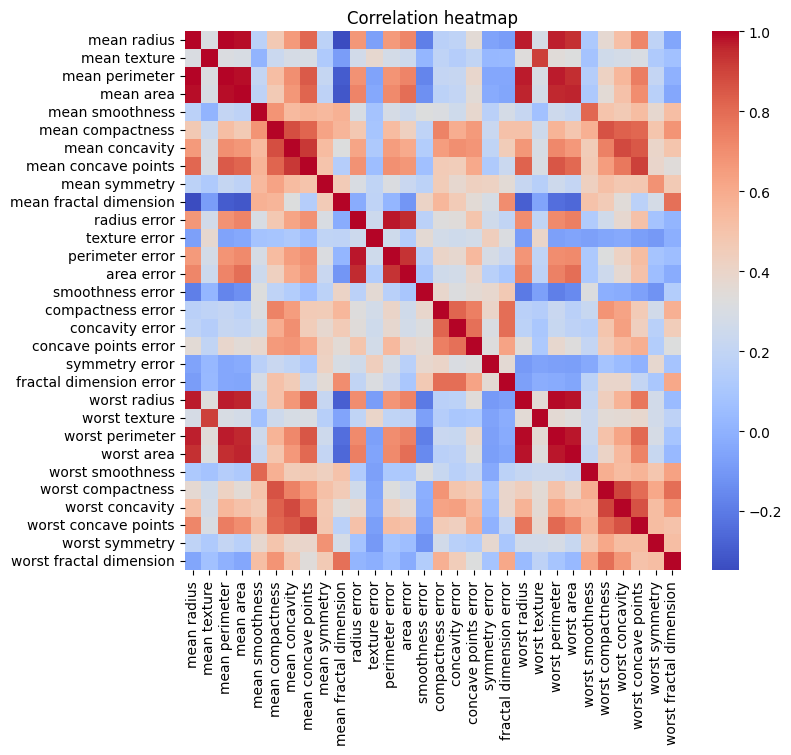

In [13]:
correlation_matrix = X_train.corr()

plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

We can see that several features are strongly correlated. For example, "mean radius", "mean perimeter" and "mean area" are very strongly correlated with each other. They are also correlated to all other features in the same way. This indicates that these 3 features provide the same or very similar information about the tumor shape.

Before designing a machine learning pipeline, we should check the type of data that we are dealing with:

In [14]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

All features are numerical and unbounded, suggesting we should scale all of them before training.

## Task 2: Machine Learning Pipeline


### Task 2.1 Implement a **machine learning pipeline** that includes **preprocessing and cross-validation** to optimize the model's hyperparameters. 
- Use the pipeline with **linear SVM** and **regularized logistic regression with L1 and elastic-net regularization** to predict whether a tumor is **malignant or benign** based on the given features. 
- Create a table to show the performance of the different models. 
- Plot the confusion matrix and ROC curve for each model.

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Preprocessing: Standardize numerical features
preprocessor = make_column_transformer(
    (StandardScaler(), X.columns),  # Standardize all features
    verbose_feature_names_out=False,
)

In [16]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC 

def optimise_hyperparameters(model: BaseEstimator, param_grid: dict):
    preprocess_and_train = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("classify", model)
    ])

    grid_search = GridSearchCV(
        estimator=preprocess_and_train,
        param_grid=param_grid,
        n_jobs=-1,
        error_score=0,
        refit=True
    )

    # Fit GridSearchCV
    return grid_search.fit(X_train, y_train) 

# defining parameter range 
cv_svc = optimise_hyperparameters(
    LinearSVC(dual="auto", random_state=42),
    {'classify__C': [0.1, 1]}
)
model_svc=cv_svc.best_estimator_

cv_lasso = optimise_hyperparameters(
    LogisticRegression(
        penalty="l1",  # Lasso (L1 regularization)
        solver="liblinear",  # Required for L1 penalty
        max_iter=100000,
    ),
    {'classify__C': np.logspace(-3, 3, 10)}
)
model_Lasso = cv_lasso.best_estimator_

cv_en = optimise_hyperparameters(
    LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        max_iter=100000,
    ),
    {'classify__C': np.logspace(-3, 3, 10), "classify__l1_ratio": [0.1, 0.5, 0.9]}
)
model_EN = cv_en.best_estimator_

print("Done training models")

Done training models


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline

def get_metrics(name: str, model: Pipeline, use_proba: bool = False):
    # Predictions
    y_pred_test = model.predict(X_test)

    # Probabilities for AUC computation
    y_proba_test = model.predict_proba(X_test)[:, 1] if use_proba else model.decision_function(X_test)

    # Compute classification metrics
    metrics_test = {
        "Model": name,
        "Accuracy": balanced_accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test),
        "Recall": recall_score(y_test, y_pred_test),
        "F1-score": f1_score(y_test, y_pred_test),
        "AUC": roc_auc_score(y_test, y_proba_test),
    }
    
    return metrics_test

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_df.loc[0] = get_metrics("SVC", model_svc)
results_df.loc[1] = get_metrics("Logistic Regression (L1)", model_Lasso)
results_df.loc[2] = get_metrics("Logistic Regression (ElasticNet)", model_EN)

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,SVC,0.979505,0.988636,0.977528,0.983051,0.996463
1,Logistic Regression (L1),0.979505,0.988636,0.977528,0.983051,0.997919
2,Logistic Regression (ElasticNet),0.973887,0.988506,0.966292,0.977273,0.996463


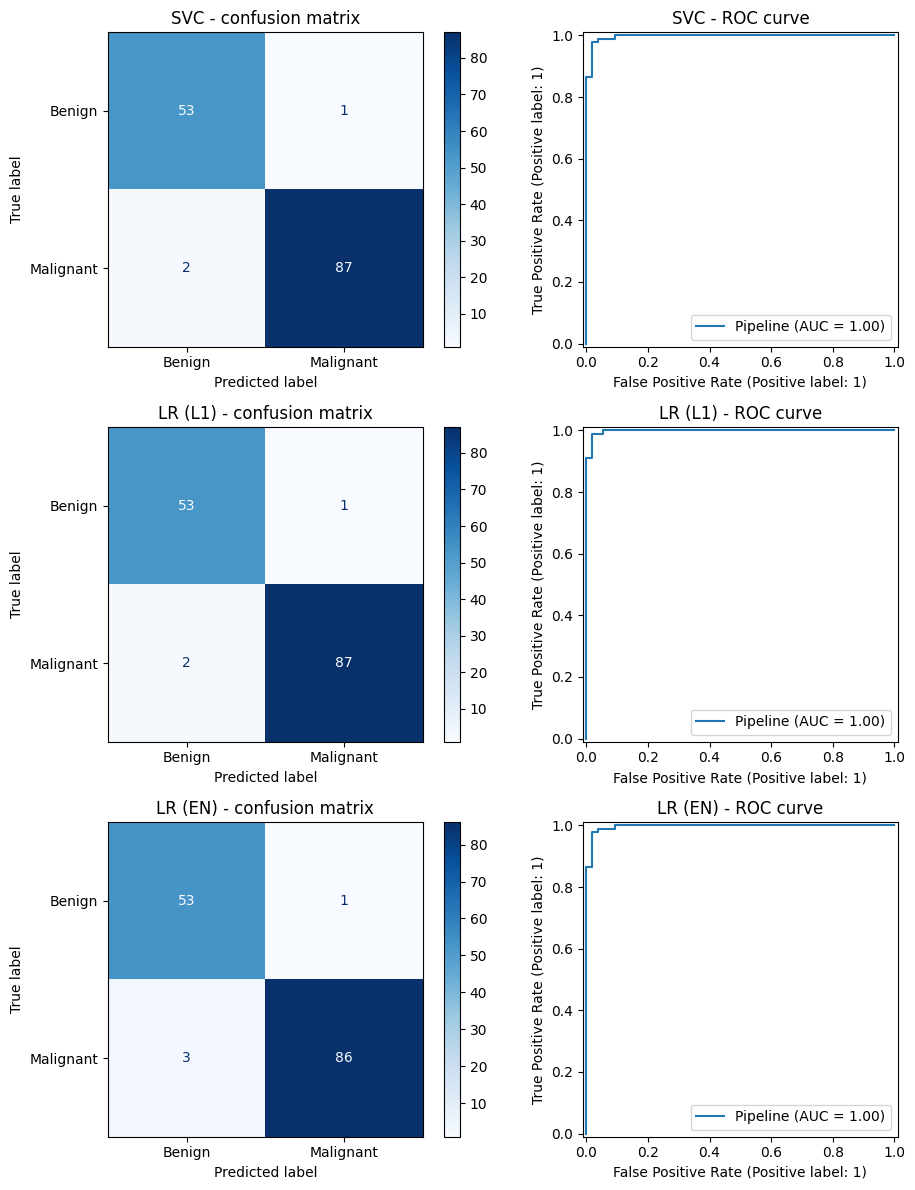

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def plot_evaluation_graphs(models: list[tuple[str, Pipeline]]):
    fig, ax = plt.subplots(len(models), 2, figsize=(10, 4 * len(models)))

    for i, model in enumerate(models):
        # Confusion Matrix
        ax[i][0].set_title(f"{model[0]} - confusion matrix")
        ConfusionMatrixDisplay.from_estimator(model[1], X_test, y_test, display_labels=["Benign", "Malignant"], ax=ax[i][0], cmap="Blues")

        # ROC Curve
        ax[i][1].set_title(f"{model[0]} - ROC curve")
        RocCurveDisplay.from_estimator(model[1], X_test, y_test, ax=ax[i][1])

    fig.tight_layout()
    plt.show()

models = [
    ("SVC", model_svc),
    ("LR (L1)", model_Lasso),
    ("LR (EN)", model_EN),
]
plot_evaluation_graphs(models)

### Task 2.2 Plot the models coefficients variability across folds for the linear models

In [19]:
from sklearn.model_selection import RepeatedKFold, cross_validate

def get_coefficients(model: Pipeline):
    # Get feature names from the preprocessing pipeline
    feature_names = model[:-1].get_feature_names_out()

    # Define repeated k-fold cross-validation
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

    # Perform cross-validation and store estimators
    cv_model = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        return_estimator=True,
        n_jobs=-1,
    )

    # Extract coefficients from trained models
    return pd.DataFrame(
        [est[-1].coef_.ravel() for est in cv_model["estimator"]],  # Extracting coefficients correctly
        columns=feature_names
    )

coefficients = [
    ("SVC", get_coefficients(model_svc)),
    ("LR (L1)", get_coefficients(model_Lasso)),
    ("LR (EN)", get_coefficients(model_EN)),
]

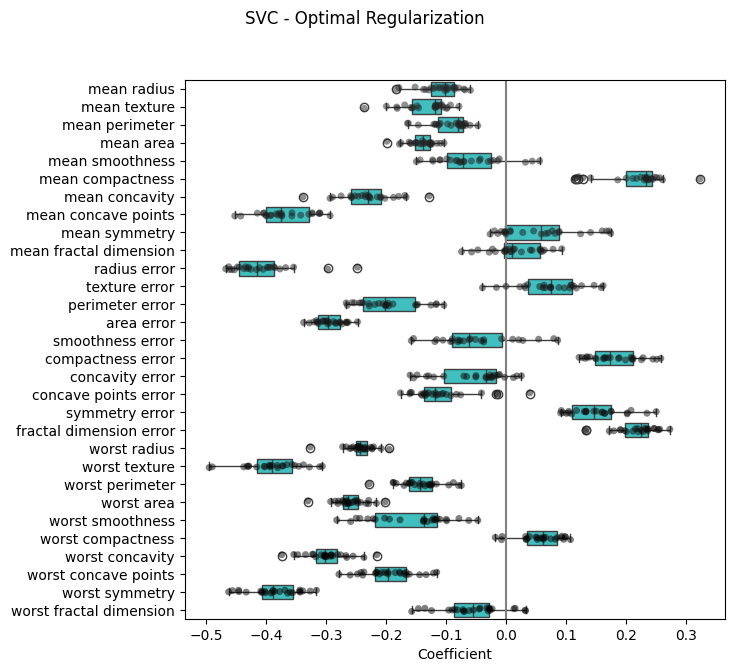

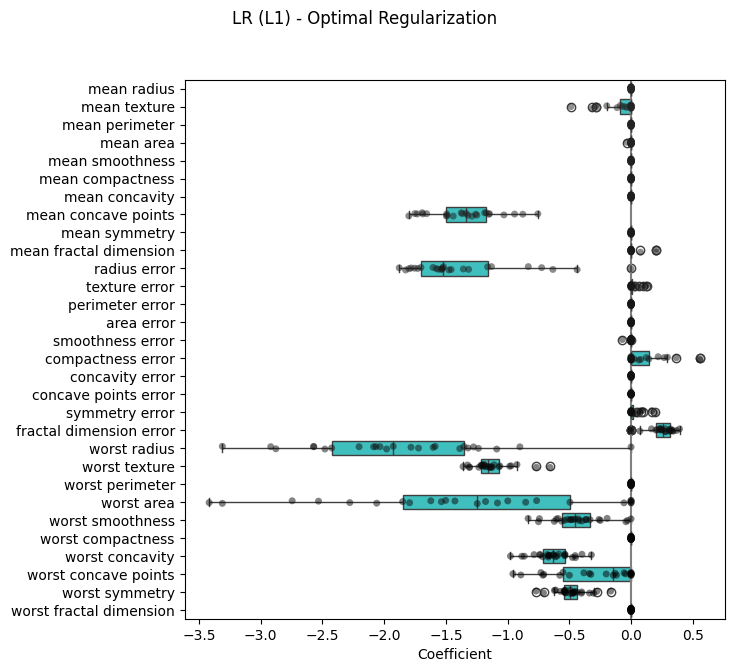

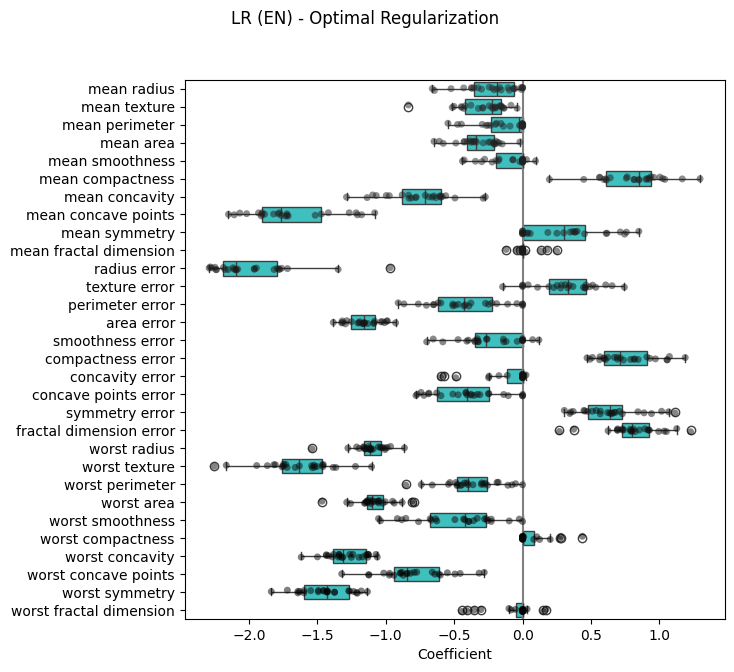

In [20]:
# Plot coefficient variability
def plot_coefficients(name: str, coefs: pd.DataFrame):
    plt.figure(figsize=(9, 7))
    sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
    sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
    plt.axvline(x=0, color=".5")
    plt.xlabel("Coefficient")
    plt.suptitle(f"{name} - Optimal Regularization")
    plt.subplots_adjust(left=0.3)
    plt.show()

for i, coefficient in enumerate(coefficients):
    plot_coefficients(coefficient[0], coefficient[1])

Discussion: Are the coefficents across the different models similar?

### Task 2.3 Plot the permutation feature importance for the different models.

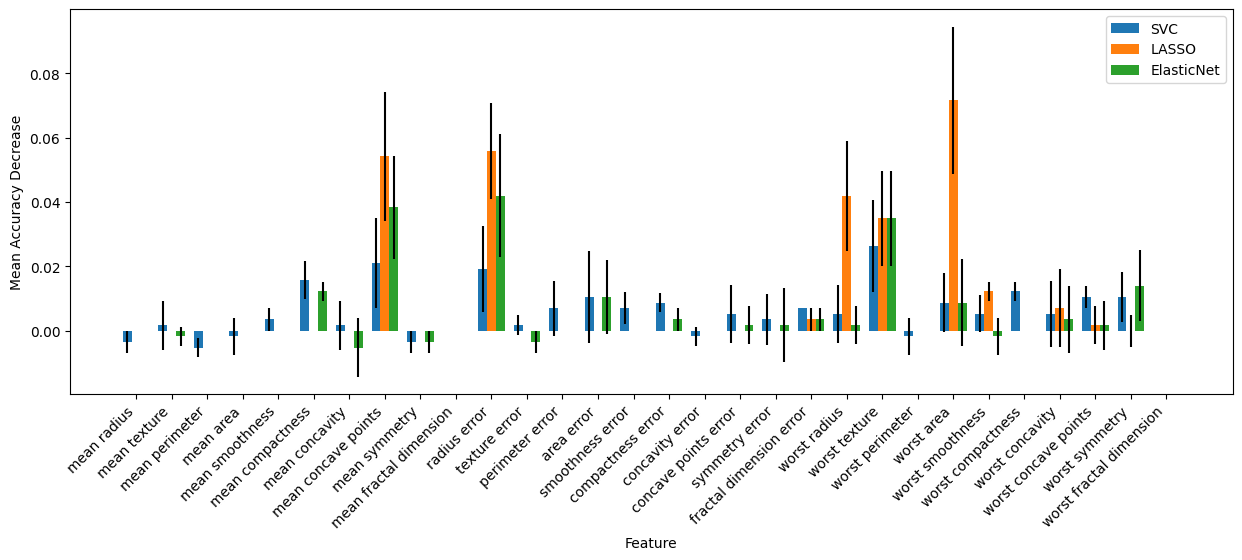

In [21]:
from sklearn.inspection import permutation_importance

# Extract feature names
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]

# Compute permutation importance on the final estimator (Lasso Logistic Regression)
result_svc = permutation_importance(
    model_svc, X_test, y_test, n_repeats=4, random_state=42, n_jobs=-1
)

result_lasso = permutation_importance(
    model_Lasso, X_test, y_test, n_repeats=4, random_state=42, n_jobs=-1
)

result_en = permutation_importance(
    model_EN, X_test, y_test, n_repeats=4, random_state=42, n_jobs=-1
)

# Plot feature importances
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(0, 30) + 0.25, result_svc.importances_mean, yerr=result_svc.importances_std, width=0.25, label="SVC")
ax.bar(np.arange(0, 30) + 0.50, result_lasso.importances_mean, yerr=result_lasso.importances_std, width=0.25, label="LASSO")
ax.bar(np.arange(0, 30) + 0.75, result_en.importances_mean, yerr=result_en.importances_std, width=0.25, label="ElasticNet")
ax.set_xticks(np.arange(0, 30) + 0.5, feature_names, rotation=45, ha="right")
ax.legend()
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_xlabel("Feature")

plt.show()

Discussion: Are the feature coefficients simimar to the permutation importance for the different models?

### Task 2.4 Implement a similar pipeline for tree-based models and use the pipeline with Random Forest and Gradient Boosting trees to predict the tumour malignancy from the other features.
- Create a table to show the performance of the different models. 
- Plot the confusion matrix and ROC curve for each model.

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Random Forest Model
rf_model = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=4, random_state=0, n_estimators=100, n_jobs=-1)
)

# Fit Random Forest model
rf_model.fit(X_train, y_train)

# Gradient Boosting Model
gb_model = make_pipeline(
    preprocessor,
    GradientBoostingClassifier(max_depth=4, random_state=0, n_estimators=100)
)

# Fit Gradient Boosting model
gb_model.fit(X_train, y_train)

print("Done training models")

Done training models


In [23]:
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_df.loc[0] = get_metrics("Random Forest", rf_model, use_proba=True)
results_df.loc[1] = get_metrics("Gradient Boosting", gb_model)

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Random Forest,0.966604,0.967033,0.988764,0.977778,0.996255
1,Gradient Boosting,0.959010,0.977011,0.955056,0.965909,0.995214


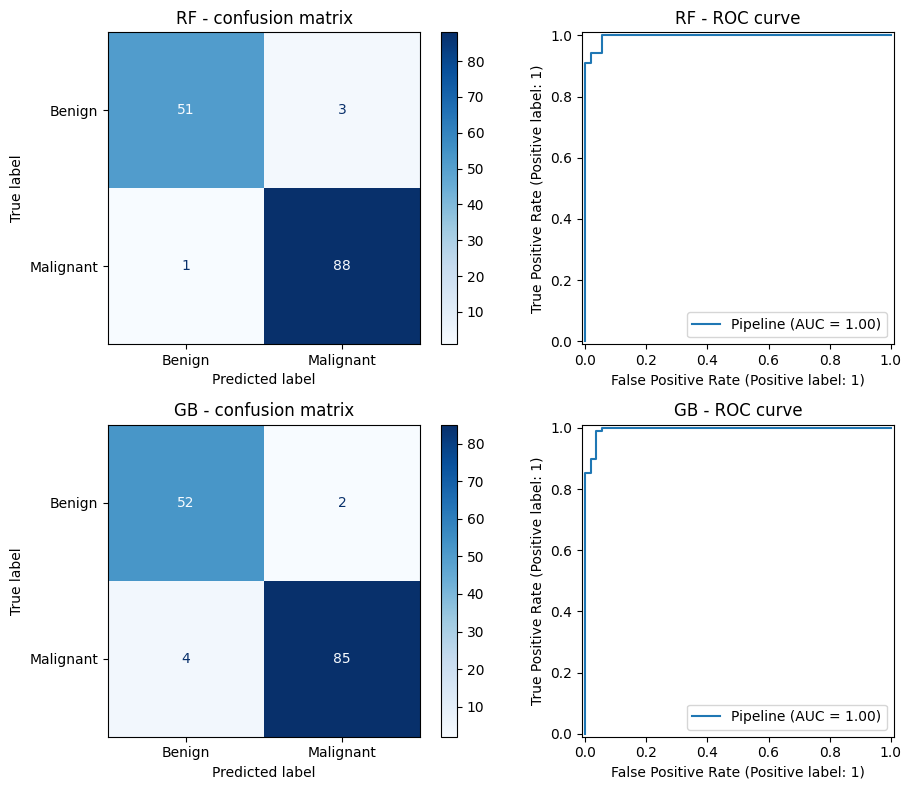

In [24]:
models = [
    ("RF", rf_model),
    ("GB", gb_model)
]

plot_evaluation_graphs(models)

### Task 2.5 Plot the feature importance for the different tree-based models

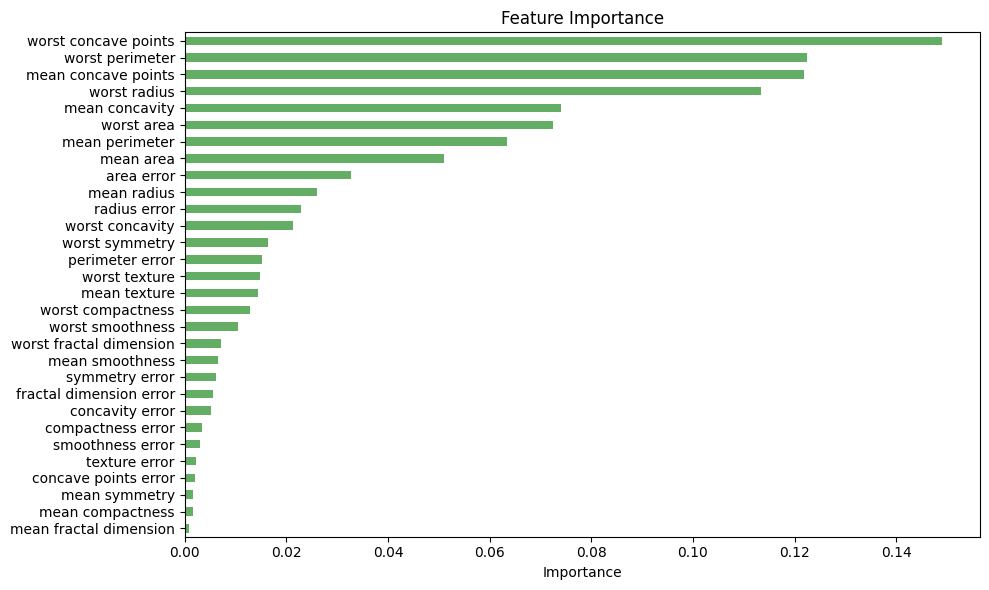

In [25]:
def plot_feature_importance(model: Pipeline):
    # Access the RandomForestClassifier inside the pipeline
    random_forest_classifier = model.steps[-1][1]

    # Get feature importances
    feature_importances = random_forest_classifier.feature_importances_

    # Extract feature names from the preprocessor
    feature_names = preprocessor.get_feature_names_out()

    # Create a pandas Series for better visualization
    importances_series = pd.Series(feature_importances, index=feature_names)

    # Plot feature importances
    fig, ax = plt.subplots(figsize=(10, 6))
    importances_series.sort_values().plot.barh(ax=ax, color="forestgreen", alpha=0.7)
    ax.set_title("Feature Importance")
    ax.set_xlabel("Importance")
    fig.tight_layout()
    plt.show()

plot_feature_importance(rf_model)

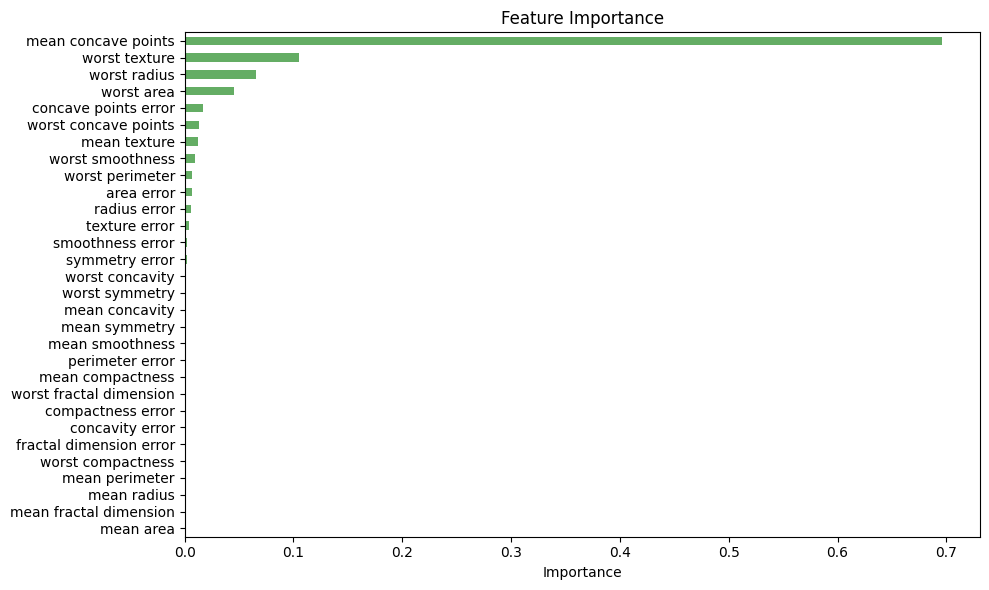

In [26]:
plot_feature_importance(gb_model)

### Task 2.6 Plot the permutation feature importance for the different tree-based models

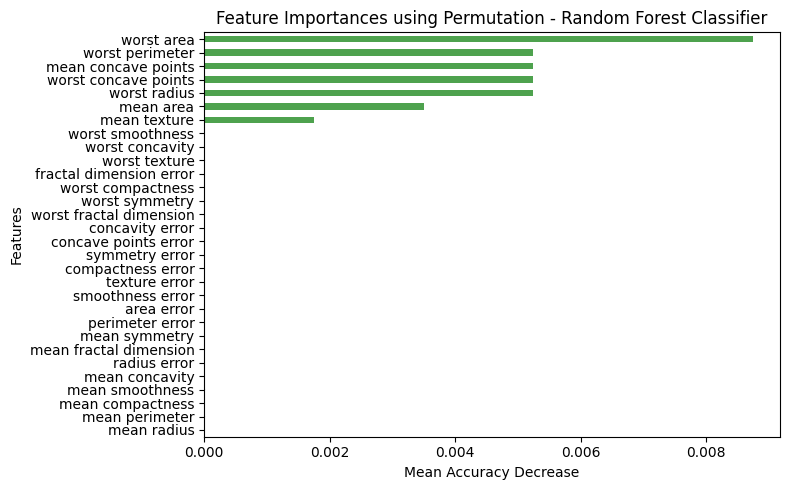

In [27]:
def plot_feature_importance(model):
    # Extract feature names
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]

    # Compute permutation importance on the final estimator (RandomForestClassifier inside the pipeline)
    result = permutation_importance(
        model, X_test, y_test, n_repeats=4, random_state=42, n_jobs=2
    )

    # Convert to Pandas Series for easy plotting
    rf_importances = pd.Series(result.importances_mean, index=feature_names)

    # Plot feature importances with error bars
    fig, ax = plt.subplots(figsize=(8, 5))
    rf_importances.sort_values().plot.barh(yerr=result.importances_std, ax=ax, color="forestgreen", alpha=0.8)
    ax.set_title("Feature Importances using Permutation - Random Forest Classifier")
    ax.set_xlabel("Mean Accuracy Decrease")
    ax.set_ylabel("Features")
    fig.tight_layout()
    plt.show()

plot_feature_importance(rf_model)

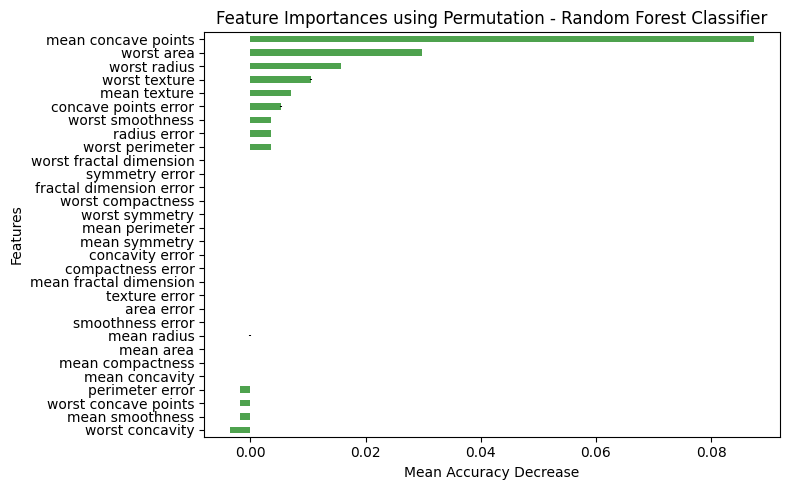

In [28]:
plot_feature_importance(gb_model)

Discussion: Are the feature importance and permutation feature importance similar for the different models?

### Task 2.7  For the best tree-based model use partial dependence plot to investigate dependence between the target response and each feature


Gradient Boosting Performance:
Accuracy: 0.9590
AUC: 0.9952
F1-score: 0.9659

Random Forest Performance:
Accuracy: 0.9666
AUC: 0.9963
F1-score: 0.9778

Best Model Selected: Random Forest


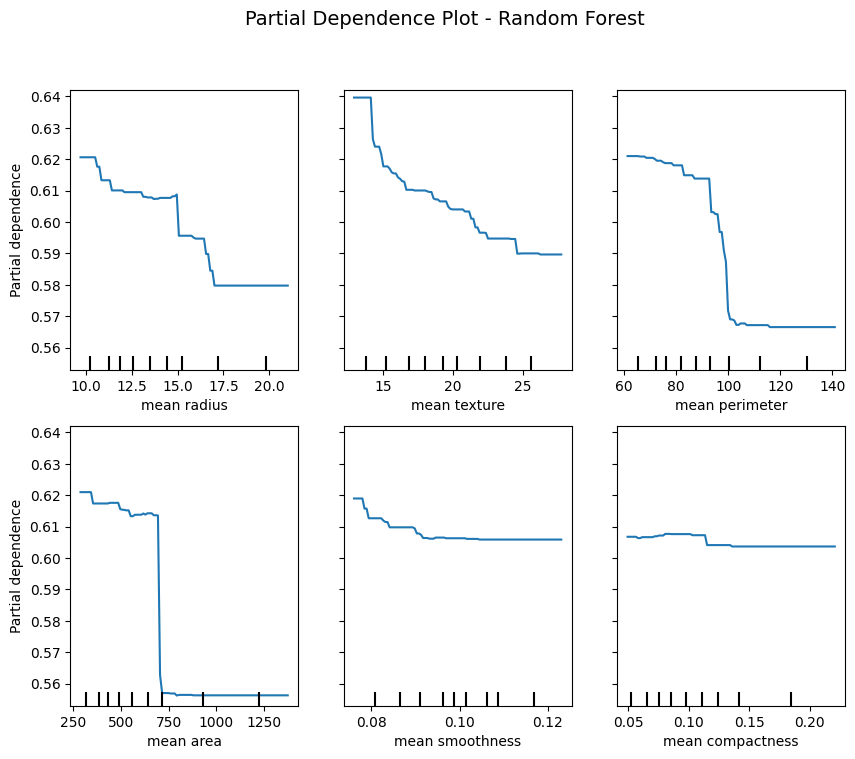

In [29]:
from sklearn.inspection import PartialDependenceDisplay

# Predictions & Probabilities for AUC Computation
y_pred_gb = gb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

y_proba_gb = gb_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute classification metrics
metrics = {
    "Gradient Boosting": {
        "Accuracy": balanced_accuracy_score(y_test, y_pred_gb),
        "AUC": roc_auc_score(y_test, y_proba_gb),
        "F1-score": f1_score(y_test, y_pred_gb),
    },
    "Random Forest": {
        "Accuracy": balanced_accuracy_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf),
        "F1-score": f1_score(y_test, y_pred_rf),
    }
}

# Print performance comparison
for model, scores in metrics.items():
    print(f"\n{model} Performance:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")

# Select the best model (based on AUC)
best_model = gb_model if metrics["Gradient Boosting"]["AUC"] > metrics["Random Forest"]["AUC"] else rf_model
best_model_name = "Gradient Boosting" if best_model == gb_model else "Random Forest"
print(f"\nBest Model Selected: {best_model_name}")

# Partial Dependence Plot (for best model)
features_to_plot = preprocessor.get_feature_names_out()[:6]  # Plot first 6 features for clarity

fig, ax = plt.subplots(figsize=(10, 8))
PartialDependenceDisplay.from_estimator(best_model, X_test, features=features_to_plot, ax=ax, n_jobs=-1)
plt.suptitle(f"Partial Dependence Plot - {best_model_name}", fontsize=14)
plt.show()

Notice how varying `mean_perimeter` and `mean_area` produces a very similar response: this agrees with what we saw in the correlation matrix at the beginning of Part 2 (the two features convey essentially the same information).

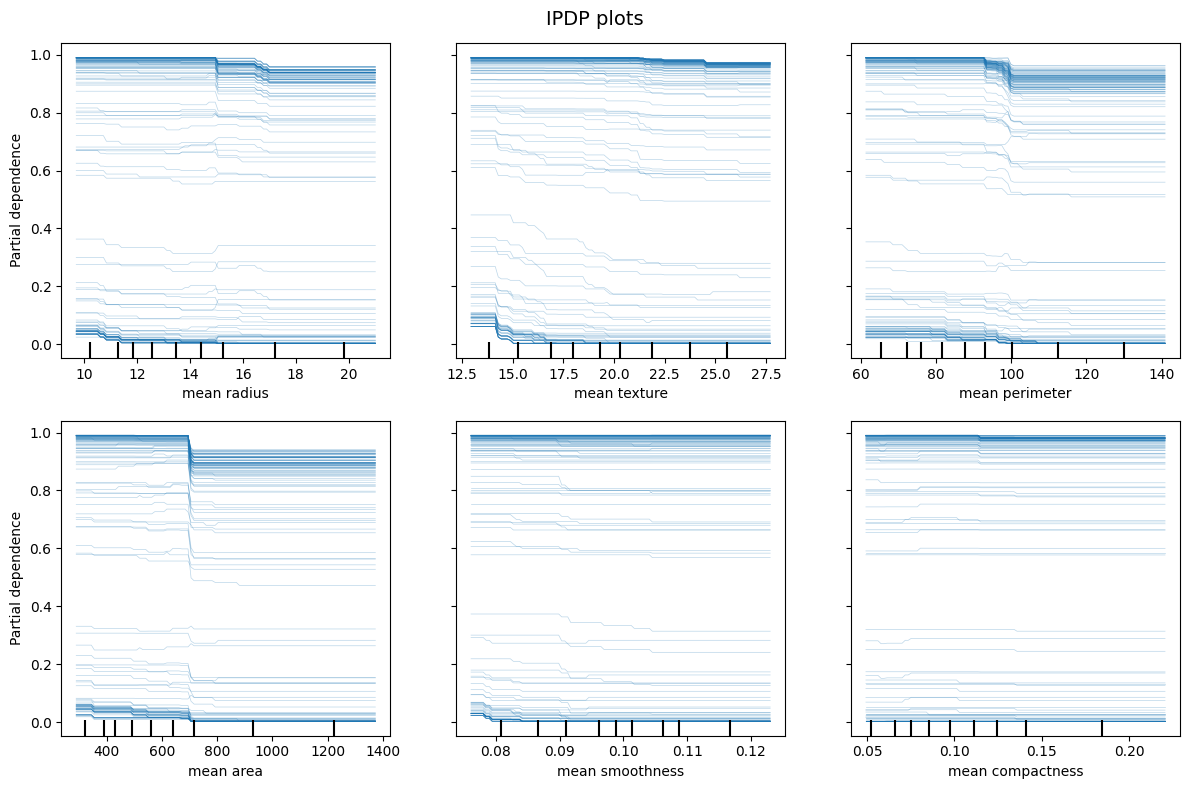

In [30]:
# Generate Individual Partial Dependence Plots (IPDP)
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(best_model, X_test, features=features_to_plot, kind="individual", ax=ax, n_jobs=-1)

plt.suptitle("IPDP plots", fontsize=14)
plt.tight_layout()
plt.show()

## Task 3: Include feature selection within the cross-validation pipeline implemented in Task 1 and try two different feature selection strategies (select k best and recursive feature elimination) with the linear SVM model.
- Create a table to show the performance of the different models. 
- Plot the confusion matrix and ROC curve for each model.

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

def make_feature_selection_pipline(feature_selection_step):
    param_grid = {'linearsvc__C': [0.1, 1,]}

    model_svc_select = make_pipeline(
        preprocessor,
        feature_selection_step,
        LinearSVC(dual="auto", random_state=42)
    )

    return GridSearchCV(
        estimator=model_svc_select,
        param_grid=param_grid,
        n_jobs=-1,
        error_score=0,
        verbose=1,
        refit=True,
    )

kbest_pipeline = make_feature_selection_pipline(
    SelectKBest(score_func=f_classif, k=10)
)

# Fit GridSearchCV
kbest_result = kbest_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_pipeline = make_feature_selection_pipline(
    RFE(estimator=LogisticRegression(max_iter=5000, solver="liblinear"), n_features_to_select=10),
)

rfe_result=rfe_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [33]:
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_df.loc[0] = get_metrics("KBest", kbest_result.best_estimator_)
results_df.loc[1] = get_metrics("RFE", rfe_result.best_estimator_)

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,KBest,0.973887,0.988506,0.966292,0.977273,0.998335
1,RFE,0.975864,0.977778,0.988764,0.983240,0.997711


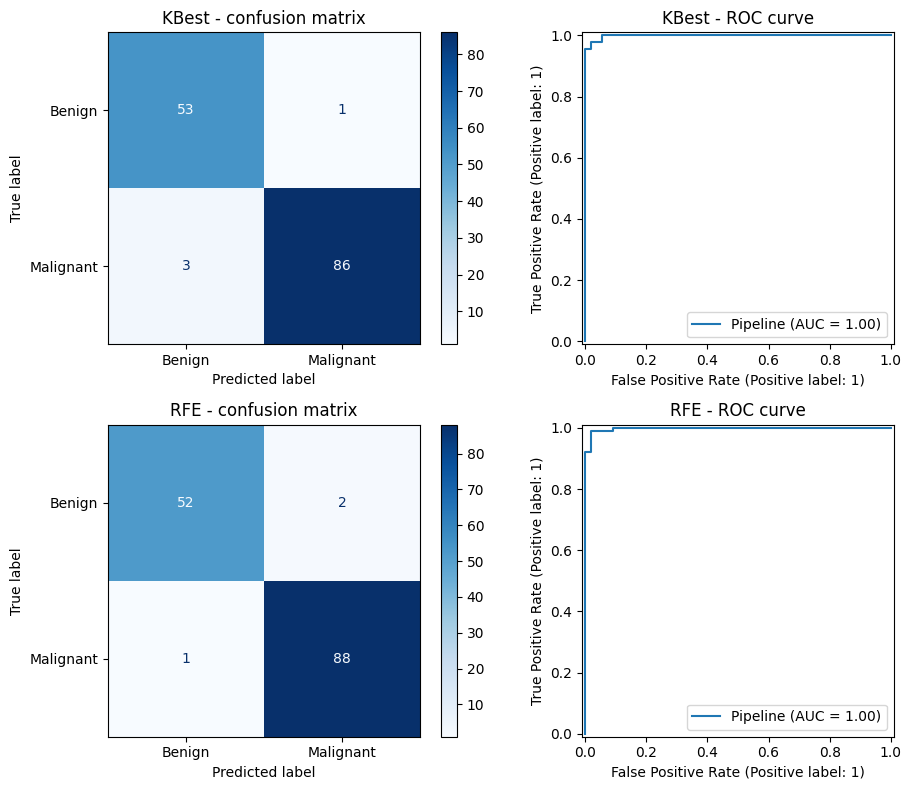

In [34]:
plot_evaluation_graphs([
    ("KBest", kbest_result.best_estimator_),
    ("RFE", rfe_result.best_estimator_)
])

Discussion: Did the model performance improved with feature selection?

### Task 3.2 Plot the coefficientes variability across folds for the linear model based on the selected features.

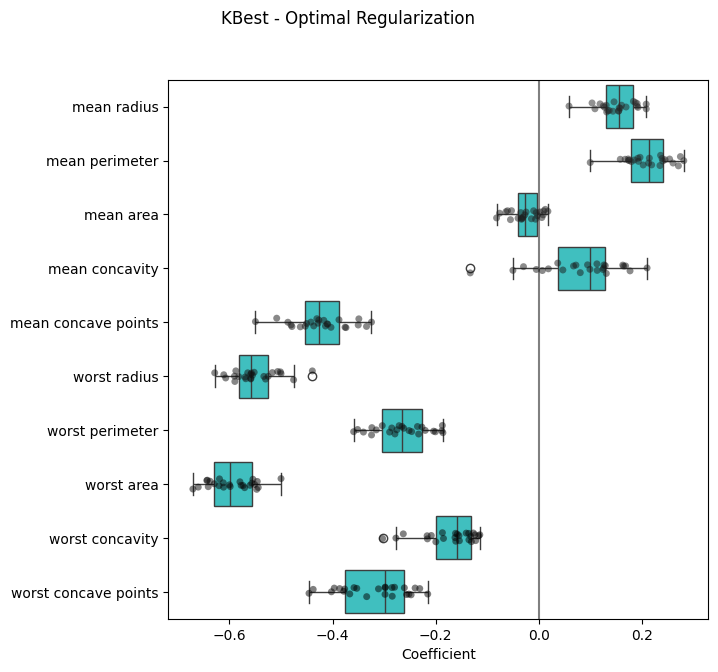

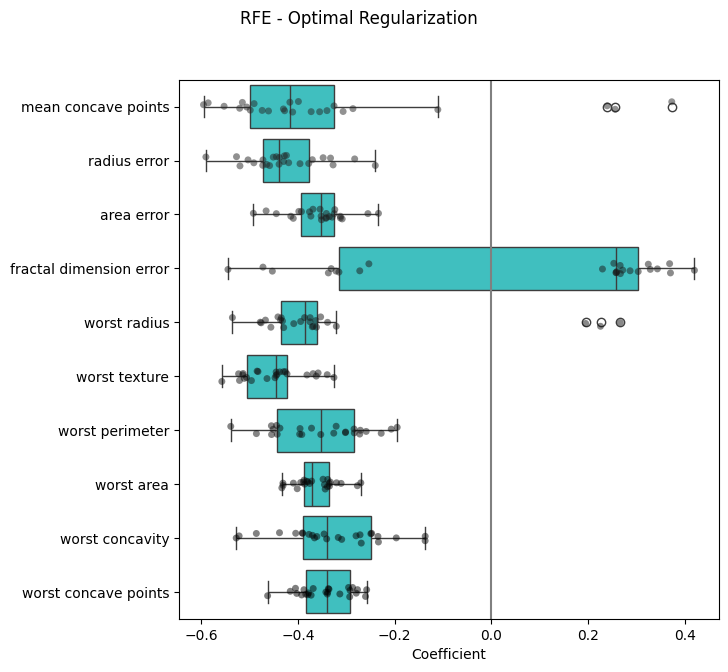

In [35]:
coefs_kbest = get_coefficients(kbest_result.best_estimator_)
plot_coefficients("KBest", coefs_kbest)

coefs_rfe = get_coefficients(rfe_result.best_estimator_)
plot_coefficients("RFE", coefs_rfe)

Discussion: Are similar features selected using the different strategies?